# IUM projekt - Zniżki dla klientów

## Zadanie
- Zinterpretować: “Niektórzy  klienci  nie  mogą  zdecydować  się  na zakup oglądając  produkt  na  stronie – ale pewnie  gdybyśmy  wiedzieli,  które  to  są  osoby,  to odpowiednia zniżka  skłoniłaby ich do zakupu."  
- Analiza danych.  
- Doprecyzowanie, przeanalizowanie problemu i wdrozenie aplikacji bazującej na mikroserwisach.  

## Problem biznesowy
Stworzenie systemu, który umożliwi zaproponowanie klientom niezdecydowanym, zniżki takiej, która zachęci ich do zakupu, ale równocześnie bedzie jak najmniejsza.  
Istnieje kilka interpretacji zadania:  
1. Model ma mówić czy klient jest niezdecydowany
2. Model ma mówić czy klient jest niezdecydowany i jakoś optymalizować stawkę zniżki
3. Model ma mówić czy opłaca się zaproponować zniżkę klientowi
4. Model ma wyznaczać wartośc zniżki którą powinno się zaproponować każdemu klientówi na podstawie jego historii
5. Przewidywać, po ilu wyświetlonych produktach klient, będzie chciał kupić produkt.  

Zakładamy interpretację nr.4.

## Zadania modelowania
- zadanie grupowania ( grupujemy klientów, żeby wspomóc przewidywanie zniżki )
- zadanie regresji ( znalezienie takiej znizki, która spowoduje, że klient zdecyduje się na zakup, ale firma zarobi jak najwięcej )

## Założenia
* Będziemy na zbiorze testowym sprawdzać czy dobrze przewidzieliśmy, że klient dokona zakupu. To znaczy, że sprawdzamy historie klienta i jeżeli wyświetlał produkty a przy danej zniżce i dokonał zakupu, to oznacza, że nasz model również powinien to przewidzieć.
* Odpowiedna zniżka to taka, która zachęci klienta do zakupu. Przy czym musi ona przynieść jak najwiekszy zysk firmie. To znaczy, że znajdujemy pierwszą zniżkę dla której model przewidzi, że klient dokona zakupu.
* Zakładamy, że testów online nie będziemy mogli przeprowadzić, ograniczymy się wiec do estymacji jakości modelu.

## Kryteria sukcesu
- Stworzenie systemu, który przyniesie jak największy zysk firmie.  
Składa się na to zmotywowanie do zakupu jak największej ilości klientów, ale nie kosztem straty wynikającej z za dużej zniżki.  
- Chcemy, żeby nasz model miał jak największy stosunek *liczby zaoferowanych zniżek* / *sumy oferowanych zniżek*

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
import pandas as pd

## Wykonujemy czyszczenie danych
Procedura opisana w pliku clean_data.ipynb

In [2]:
products = pd.read_json(path_or_buf='data/products.jsonl', lines=True)
products.info()

products_clean = pd.read_json(path_or_buf='data/products_clean.jsonl', lines=True)
products_clean.info()

products = products_clean

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319 entries, 0 to 318
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   product_id     319 non-null    int64  
 1   product_name   319 non-null    object 
 2   category_path  319 non-null    object 
 3   price          319 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 10.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308 entries, 0 to 307
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   product_id    308 non-null    int64  
 1   product_name  308 non-null    object 
 2   category      308 non-null    object 
 3   price         308 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 9.8+ KB


In [3]:
sessions = pd.read_json(path_or_buf='data/sessions.jsonl', lines=True)
sessions.info()

sessions_clean = pd.read_json(path_or_buf='data/sessions_clean.jsonl', lines=True)
sessions_clean.info()

sessions = sessions_clean

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56883 entries, 0 to 56882
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   session_id        56883 non-null  int64         
 1   timestamp         56883 non-null  datetime64[ns]
 2   user_id           54075 non-null  float64       
 3   product_id        54048 non-null  float64       
 4   event_type        56883 non-null  object        
 5   offered_discount  56883 non-null  int64         
 6   purchase_id       3117 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 3.0+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53468 entries, 0 to 53467
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   session_id        53468 non-null  int64         
 1   timestamp         53468 non-null  datetime64[ns]
 

### Najważniejsze obserwacje:
- niektóre produkty mają ujemną cenę, więc można założyć, że wystarczy ją zanegować
- niektóre produkty mają nieprawdopodobnie wysoką cenę, powyżej miliona, zakładamy, więc że cena jest niepoprawna i usuwamy ten wiersz
- długa ścieżka kategori wynika z hierarchii strony web, wiec skracamy ścieżkę kategorii
- przed zakupem produktu najpierw klient ogląda produkt, można więc uzupełnić product_id wartością zdarzenia powyżej. Gdybyśmy usuwali rekordy z wartościami nullowymi w zdarzeniach zakupu 176 sesji, które zakończyły się powodzeniem, zostałoby niepoprawnie uznane za nieudane.
- zostawiamy tylko wpisy o produktach które znamy
- metoda uzupełnienia wartością rekordu wyżej będzie w znakomitej większości uzupełniać poprawnie user_id. Jedyna sytuacja brzegowa w której potencjalnie (p=0.5) się pomyli ma bardzo małe prawdopodobieństo wystąpienia, dotyczy zera lub pojedynczych rekordów i dodatkowo dotyczy tylko eventów VIEW_PRODUCT więc spokojnie można tak uzupełniać.

## Wykonujemy analizę danych
Wnioski z analizy przeprowadzonej w pliku clean_data.ipynb

In [4]:
bought = sessions[sessions["event_type"] == "BUY_PRODUCT"]
views = sessions[sessions["event_type"] == "VIEW_PRODUCT"]
successful_sessions = sessions[sessions["session_id"].isin(bought["session_id"])]
unsuccessful_sessions = sessions[~sessions["session_id"].isin(bought["session_id"])]
successful_views_count = successful_sessions.groupby("session_id")["user_id"].agg('count') - 1
unsuccessful_views_count = unsuccessful_sessions.groupby("session_id")["user_id"].agg('count')

bought_with_discount = bought[bought["offered_discount"] != 0]
successful_sessions_with_discount = sessions[sessions["session_id"].isin(bought_with_discount["session_id"])]
sessions_without_discount = sessions[sessions["offered_discount"] == 0]
sessions_with_discount = sessions[sessions["offered_discount"] != 0]
successful_sessions_without_discount = sessions_without_discount[sessions_without_discount["session_id"].isin(bought["session_id"])]
percentage_successful_with_discount =  successful_sessions_with_discount.shape[0] / sessions_with_discount.shape[0] * 100
percentage_successful_without_discount = successful_sessions_without_discount.shape[0] / sessions_without_discount.shape[0] * 100

bought_by_user_id = bought.groupby("user_id")["product_id"].agg("count")
bought_by_user_id_unique = bought.groupby("user_id")["product_id"].nunique()

print(f" Tyle zakupów dokonali klienci: {sum(bought_by_user_id.values)}")
print(f" Suma zakupów różnych produktów dla wszystkich klientów: {sum(bought_by_user_id_unique.values)}")

bought_by_user_category = bought.groupby("user_id")["category"].agg("count")
bought_by_user_category_ = bought.groupby("user_id")["category"].nunique()

print(f" \nTyle zakupów dokonali klienci: {sum(bought_by_user_category.values)}")
print(f" Suma zakupów różnych kategorii dla wszystkich klientów: {sum(bought_by_user_category_.values)}")

 Tyle zakupów dokonali klienci: 3103
 Suma zakupów różnych produktów dla wszystkich klientów: 1748
 
Tyle zakupów dokonali klienci: 3103
 Suma zakupów różnych kategorii dla wszystkich klientów: 1748


Na początku próbowaliśmy zinterpretować zadanie w sposób nr.1. Po wstępnej analizie danych dało się już zauważyć pewne problemy tego podejścia. Klienci zdają się kupować te same produkty. Zdecydowaliśmy się, więc do podjęcia się interpretacji nr.4.

In [5]:
bought_by_category = bought.groupby("category")["session_id"].agg("count")
bought_by_category_ = bought.groupby("category")["session_id"].nunique()
print("\nWszystkie zakupy w danej kategorii:\n")
print(bought_by_category)
print("Suma:")
print(sum(bought_by_category.values))
print("\nPowtarzające się zakupy w danej kategorii:\n")
print(bought_by_category_)
print("Suma:")
print(sum(bought_by_category_.values))


Wszystkie zakupy w danej kategorii:

category
Anteny RTV                           195
Biurowe urządzenia wielofunkcyjne    212
Gry PlayStation3                     219
Gry Xbox 360                         210
Gry komputerowe                      228
Monitory LCD                         223
Odtwarzacze DVD                      193
Odtwarzacze mp3 i mp4                173
Okulary 3D                           221
Słuchawki                            191
Tablety                              215
Telefony komórkowe                   200
Telefony stacjonarne                 223
Zestawy głośnomówiące                194
Zestawy słuchawkowe                  206
Name: session_id, dtype: int64
Suma:
3103

Powtarzające się zakupy w danej kategorii:

category
Anteny RTV                           195
Biurowe urządzenia wielofunkcyjne    212
Gry PlayStation3                     219
Gry Xbox 360                         210
Gry komputerowe                      228
Monitory LCD                         

Da się zauważyć, że ilość sesji (tym samym zakupów) dla danej kategorii produktów jest generowana zrozkładem jednostajnym (domyślamy się, że "na rozpoczęciu sesji" po prostu jest losowana kategoria produktów, które będzie oglądać klient).

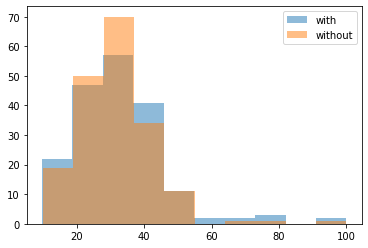

In [8]:
successful_sessions_without_discount_by_user = successful_sessions_without_discount.groupby("user_id")["session_id"].nunique()
successful_sessions_with_discount_by_user = successful_sessions_with_discount.groupby("user_id")["session_id"].nunique()
sessions_with_discount_only_valid_users = sessions_with_discount[sessions_with_discount["user_id"].isin(successful_sessions_with_discount["user_id"])]
sessions_without_discount_only_valid_users = sessions_without_discount[sessions_without_discount["user_id"].isin(successful_sessions_without_discount["user_id"])]
sessions_without_discount_by_user = sessions_without_discount_only_valid_users.groupby("user_id")["session_id"].nunique()
sessions_with_discount_by_user = sessions_with_discount_only_valid_users.groupby("user_id")["session_id"].nunique()

percentage_successful_sessions_without_discount_by_user = successful_sessions_without_discount_by_user / (sessions_without_discount_by_user) * 100
percentage_successful_sessions_with_discount_by_user = successful_sessions_with_discount_by_user / (sessions_with_discount_by_user) * 100


plt.figure()
_ = plt.hist(percentage_successful_sessions_with_discount_by_user, alpha=0.5, label='with')
_ = plt.hist(percentage_successful_sessions_without_discount_by_user, alpha=0.5, label='without')
plt.legend(loc='upper right')
plt.show()

Okazuje się, że procentowy histogram udanych sesji bez zniżek i ze zniżką jest bardzo podobny dla sesji ze zniżka i bez zniżki.

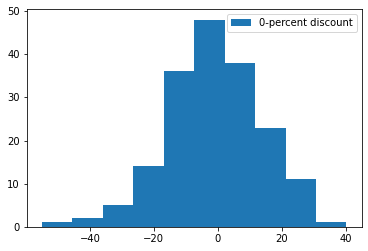

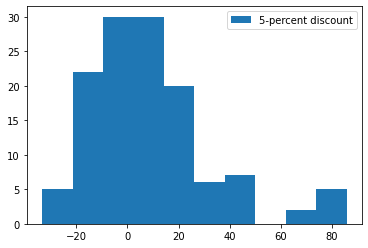

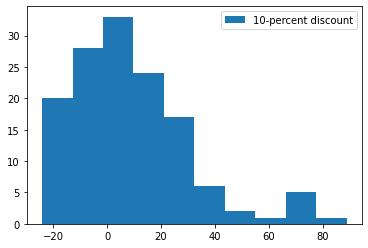

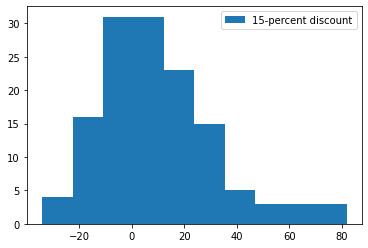

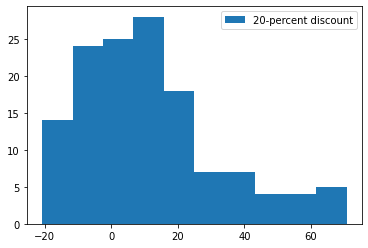

In [7]:
for i in np.arange(0,21,5):
    
    sessions_with_discount_i = sessions[sessions["offered_discount"] == i]
    successful_sessions_with_discount_i = sessions_with_discount_i[sessions_with_discount_i["session_id"].isin(bought["session_id"])]
    successful_sessions_with_discount_i_by_user = successful_sessions_with_discount_i.groupby("user_id")["session_id"].nunique()
    sessions_with_discount_i_only_valid_users = sessions_with_discount_i[sessions_with_discount_i["user_id"].isin(successful_sessions_with_discount_i["user_id"])]
    sessions_with_discount_i_by_user = sessions_with_discount_i_only_valid_users.groupby("user_id")["session_id"].nunique()

    sessions_without_discount_i = sessions[~sessions["session_id"].isin(sessions_with_discount_i["session_id"])]
    sessions_without_discount_i_by_user = sessions_without_discount_i.groupby("user_id")["session_id"].nunique()
    successful_sessions_without_discount_i = sessions_without_discount_i[sessions_without_discount_i["session_id"].isin(bought["session_id"])]
    successful_sessions_without_discount_i_by_user = successful_sessions_without_discount_i.groupby("user_id")["session_id"].nunique()
    
    percentage_successful_sessions_with_discount_i_by_user = successful_sessions_with_discount_i_by_user / (sessions_with_discount_i_by_user) * 100
    percentage_successful_sessions_without_discount_i_by_user = successful_sessions_without_discount_i_by_user / (sessions_without_discount_i_by_user) * 100
    difference_i = percentage_successful_sessions_with_discount_i_by_user - percentage_successful_sessions_without_discount_i_by_user
    difference_i.dropna(inplace=True)
    plt.figure()
    _ = plt.hist(difference_i, label=f"{i}-percent discount")
    plt.legend()
    plt.show()

Wygenerowaliśmy też histogramy przedstawiające różnicę w częstotliwości zakupów z i bez danej zniżki. Dla każdej wartości zniżki, jej wpływ ma nieco inny rozkład. Im wyższa zniżka tym bardziej i częściej zauważalny jest pozytywny jej wpływ na zachowania klientów.

## Potencjalne cechy modelu klasyfikacji
Na podstawie wyżej wypisanych danych można wnioskować, że da się z nich utworzyć cechy: 
- ile razy dany klient przegladal ten produkt
- ile razy dany klient przegladal dana kategorie
- ile razy dany klient w tej sesji przegladal produkty z tej kategorii,
- ile razy znizka zachecila go do zakupu
- ile razy kupowal cos z tej kategorii
  
W tym celu wymagany bedzie dostęp do historii eventów klienta oraz dostęp do jego najnowszych akcji.  
Nasza aplikacja powinna przetworzyć i przechowywać niektóre cechy klienta, żeby poźniej sieć neuronowa mogła na podstawie nich wnioskować, jak bardzo niezdecydowany jest klient.
Kiedy nasza aplikacja dostanie informację o nowej akcji klienta, powinna już wiedzieć jak zachowywał się w przeszłości i uwzględnić to w przewidywaniu.